## __LeNet - MNIST__ 

The MNIST database (Modified National Institute of Standards and Technology database) is a large database of handwritten digits widely used for training and testing in the field of machine learning.

This small project aims to train a LeNet model on the MNIST dataset, then try the model on actual real-life images. (Just for fun)  
 _inspired by: pyimagesearch_

![mnist.png](img/mnist.jpg)
_Source: https://github.com/cazala/mnist_

![lenet_architecture.png](img/lenet_architecture.png)
_Source: https://www.pyimagesearch.com_

# Building the model architecture

In [1]:
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dense

c:\users\yq\anaconda3\envs\tf\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def lenet(width, height, depth, classes):
    inputShape = (height, width, depth)
    model = Sequential()
    
    model.add(Conv2D(20, (5, 5), padding="same", input_shape=inputShape))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(50, (5, 5), padding="same"))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    model.add(Dense(500))
    model.add(Activation("relu"))
    
    model.add(Dense(classes))
    model.add(Activation("softmax"))
    
    return model

In [3]:
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator

from keras.datasets import mnist

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# hyperparameters

EPOCHS = 3
LR = 1e-3
BS = 64

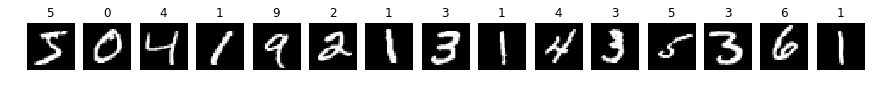

In [5]:
(Xtr, ytr), (Xte, yte) = mnist.load_data()

plt.figure(figsize=(15,4))
for i in range(15):
    plt.subplot(1, 15, i+1)
    plt.imshow(Xtr[i], cmap="gray")
    plt.title(ytr[i])
    plt.axis("off")
    
plt.show()    

In [6]:
Xtr = np.expand_dims(Xtr, -1)
Xte = np.expand_dims(Xte, -1)

Xtr = (Xtr / 255.0).astype(np.float32)
Xte = (Xte / 255.0).astype(np.float32)

ytr, yte = to_categorical(ytr, 10), to_categorical(yte, 10)

print(Xtr.shape)
print(ytr.shape)

(60000, 28, 28, 1)
(60000, 10)


In [7]:
model = lenet(28, 28, 1, 10)
opt = Adam(lr=LR, decay=LR / EPOCHS)

aug = ImageDataGenerator(rotation_range=30, width_shift_range=0.1,
                         height_shift_range=0.1, shear_range=0.2, zoom_range=0.2, fill_mode="nearest")

In [8]:
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
H = model.fit_generator(aug.flow(Xtr, ytr, batch_size=BS), validation_data=(Xte, yte), steps_per_epoch=len(Xtr) // BS,
                        epochs=EPOCHS, verbose=1)
model.save("save/digits.h5")

Epoch 1/3
937/937 [==============================] - 36s 38ms/step - loss: 0.2852 - acc: 0.9099 - val_loss: 0.0531 - val_acc: 0.9821
Epoch 2/3
937/937 [==============================] - 28s 30ms/step - loss: 0.0957 - acc: 0.9700 - val_loss: 0.0330 - val_acc: 0.9896
Epoch 3/3
937/937 [==============================] - 29s 31ms/step - loss: 0.0714 - acc: 0.9776 - val_loss: 0.0316 - val_acc: 0.9906


# Test the model!

In [9]:
import cv2
import numpy as np
import imutils
from keras.models import load_model
from imutils import contours

In [10]:
# from Deep Learning for Computer Vision by Adrian Rosebrock (pyimagesearch.com)
def preprocess(img):
    if img.shape[0] > img.shape[1]:
        img = imutils.resize(img, height=20)
    else:
        img = imutils.resize(img, width=20)
        
    padW = int((28 - img.shape[1]) / 2.0)
    padH = int((28 - img.shape[0]) / 2.0)
    
    image = cv2.copyMakeBorder(img, padH, padH, padW, padW, cv2.BORDER_CONSTANT, value=0)
    image = cv2.resize(image, (28, 28))
    
    return image

In [11]:
model = load_model("save/digits.h5")

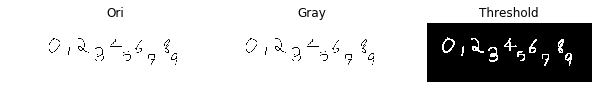

In [13]:
img = cv2.imread("test.png")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
thresh = cv2.dilate(thresh, cv2.getStructuringElement(cv2.MORPH_RECT,(5,5)))

# invert the color of the image since the architecture is train on MNIST: white text black background

plt.figure(figsize=(10, 4))

plt.subplot(131)
plt.axis("off")
plt.title("Ori")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

plt.subplot(132)
plt.axis("off")
plt.title("Gray")
plt.imshow(gray, cmap="gray")

plt.subplot(133)
plt.axis("off")
plt.title("Threshold")
plt.imshow(thresh, cmap="gray")

In [14]:
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[1]
cnts = sorted(cnts, key=cv2.contourArea, reverse=True)  # sort the contours from large to small
cnts = contours.sort_contours(cnts)[0]  # sort the contours from left to right

print(len(cnts))

10


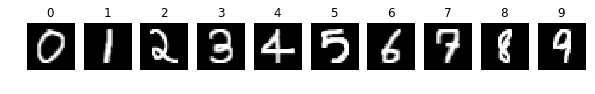

In [15]:
output = cv2.merge([gray] * 3) # convert gray image into 3 channels
plt.figure(figsize=(10, 4))

for i, c in enumerate(cnts):
    (x, y, w, h) = cv2.boundingRect(c)
    
    out = thresh[y:y+h, x:x+w]
    out = imutils.resize(out, height=20)
    out = preprocess(out)
    
    show = out.copy()
    
    out = np.expand_dims(out, 0)
    out = np.expand_dims(out, -1)
    
    sm = model.predict(out)
    prediction = np.argmax(sm, axis=-1)[0]
    
    #cv2.rectangle(output, (x, y), (x+w, y+h), (0,255,0), 1)
    cv2.putText(output, str(prediction), (x-3, y-3), cv2.FONT_HERSHEY_SIMPLEX, 0.65, (0, 255, 0), 2)
    
    plt.subplot(1, len(cnts), i+1)
    plt.axis("off")
    plt.title(str(prediction))
    plt.imshow(show, cmap="gray")
    
plt.show()    

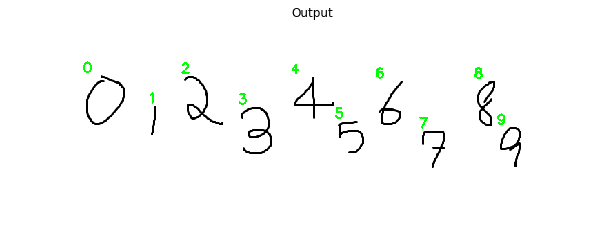

In [16]:
plt.figure(figsize=(10, 4))
plt.axis("off")
plt.title("Output")
plt.imshow(output)
plt.show()